# Brute Force Pipeline for Wildfire Detection - by Selman Tabet @ https://selman.io/

In [1]:
import os
import time


### Environment Setup

In [2]:
print(os.getcwd())

d:\Dissertation\Kaggle Data\wildfire-detection


In [3]:
import socket
print(socket.gethostname())
import os
try: # for CUDA enviroment
    os.system("nvidia-smi")
except:
    pass

Chaos


### Importing Libraries

In [4]:
# Data processing libraries
import numpy as np
import pandas as pd
from itertools import combinations
import json
import argparse

# ML libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Chart generating libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

from train_parameters import *
from customnet import *
from custom_metrics import *

from IPython import get_ipython

d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Device check

In [5]:
cuda_visible_devices = os.environ.get('CUDA_VISIBLE_DEVICES')
print(f"CUDA_VISIBLE_DEVICES: {cuda_visible_devices}")
print(tf.config.get_visible_devices())
print(tf.config.list_physical_devices('GPU'))

CUDA_VISIBLE_DEVICES: None
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


### Parse arguments from command line

In [6]:
# Detect if running in a Jupyter notebook
def in_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        else:
            return False  # Other type (terminal, etc.)
    except NameError:
        return False      # Probably standard Python interpreter
    
from_py = False
parser = argparse.ArgumentParser(
    description="Parse command line arguments")
parser.add_argument('--from-py-cfg', type=str,
                    help='Path to the config Python file')
if in_notebook():
    args = parser.parse_args([])  # Ignore sys.argv
else:
    args = parser.parse_args()
config_file_path = args.from_py_cfg
print(f"Python Config Path: {config_file_path}")

if config_file_path:
    import importlib.util
    spec = importlib.util.spec_from_file_location("config_module", config_file_path)
    config_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(config_module)
    config = config_module.config
    print("Loaded config from Python file:")
    print(config)
    # Dataset, model, and hyperparameters are mandatory and must be processed now.
    datasets_from_cfg = config.get('datasets', {})
    if datasets_from_cfg is None or len(datasets_from_cfg) == 0:
        raise ValueError("No datasets defined in config")

    models_from_cfg = config.get('keras_models', [])
    custom_models_from_cfg = config.get('custom_models', [])
    if models_from_cfg is None or len(models_from_cfg) == 0:
        if custom_models_from_cfg is None or len(custom_models_from_cfg) == 0:
            raise ValueError("No models defined in config")
    
    hyperparameters = config.get('hyperparameters')
    if hyperparameters is None or len(hyperparameters) == 0:
        print("No training hyperparameters defined in config, using defaults")
        hyperparameters = default_train_parameters.get('hyperparameters', {})
    for key, value in hyperparameters.items():
        if key not in default_train_parameters.get('hyperparameters'):
            print(f"Adding default hyperparameter {key} to {value}")
            hyperparameters[key] = value
    from_py = True # Successfully completed the import


Python Config Path: None


### Training Parameters

In [7]:
if from_py:
    datasets = datasets_from_cfg
else:
    datasets = default_train_parameters.get('datasets', {})
    
train_dirs = [datasets[ds].get('train') for ds in datasets]
test_dirs = [datasets[ds].get('test') for ds in datasets]
val_dirs = [datasets[ds].get('val') for ds in datasets]

print(train_dirs)
print(test_dirs)
print(val_dirs)

if from_py:
    base_models = models_from_cfg
    custom_models = custom_models_from_cfg
else:
    base_models = default_train_parameters.get('keras_models', [])
    custom_models = default_train_parameters.get('custom_models', [])

# Combine base_models and custom_models
all_models = base_models + custom_models
# Create a list to keep track of which models are custom
is_custom_model = [False] * len(base_models) + [True] * len(custom_models)

print("All models:", all_models)
print("Is custom model:", is_custom_model)

['dataset_1\\train', 'dataset_2\\Training', 'dataset_3']
['dataset_1\\test', 'dataset_2\\Testing', None]
['dataset_1\\val', None, None]
All models: [<function ResNet50V2 at 0x00000243AE66E7A0>, <function VGG19 at 0x00000243AE66F1A0>, <function MobileNetV3Small at 0x00000243AE66CAE0>, <Sequential name=WildfireNet, built=True>]
Is custom model: [False, False, False, True]


### Initialize data generators with augmentation

In [8]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Training Parameters

In [9]:
if from_py:
    epochs = hyperparameters.get('epochs')
    batch_size = hyperparameters.get('batch_size')
    img_height = config.get('image_height', default_train_parameters.get('image_height'))
    img_width = config.get('image_width', default_train_parameters.get('image_width'))
    optimizer_fn = config.get('optimizer', default_train_parameters.get('optimizer'))
    loss_fn = config.get('loss', default_train_parameters.get('loss'))
    callbacks_list = config.get('callbacks', default_train_parameters.get('callbacks'))
    metrics_list = config.get('metrics', default_train_parameters.get('metrics'))
else:
    epochs = default_train_parameters.get('hyperparameters').get('epochs')
    batch_size = default_train_parameters.get('hyperparameters').get('batch_size')
    img_height = default_train_parameters.get('image_height')
    img_width = default_train_parameters.get('image_width')
    optimizer_fn = default_train_parameters.get('optimizer')
    loss_fn = default_train_parameters.get('loss')
    callbacks_list = default_train_parameters.get('callbacks')
    metrics_list = default_train_parameters.get('metrics')

checkpoint_path = os.path.join("checkpoint")


### Auxiliary Functions

In [10]:
def samples_from_generators(generators):
    samples = 0
    for generator in generators:
        if generator is not None:
            samples += generator.samples
    return samples

# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def val_split(dataset, samples=None, val_size=0.2):
    # Calculate the number of samples for validation and training
    val_size = int(val_size * samples)
    train_size = samples - val_size
    # Print the sizes of the datasets
    print("Splitted dataset:")
    print(f"Training dataset size: {train_size} samples")
    print(f"Validation dataset size: {val_size} samples")
    val_dataset = dataset.take(val_size)
    train_dataset = dataset.skip(val_size)
    return train_dataset, val_dataset, train_size, val_size

def create_generators(directory, batch_size=32, img_height=224, img_width=224, augment=True, shuffle=True):
    generator = original_datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',
        shuffle=shuffle
    )
    if augment:
        augmented_generator = augmented_datagen.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=shuffle
        )
        return generator, augmented_generator
    return generator, None

def generators_to_dataset(generators, batch_size=32):
    dataset = None
    for generator in generators:
        if generator is not None:
            if dataset is None:
                dataset = create_dataset(generator, batch_size)
            else:
                dataset = dataset.concatenate(create_dataset(generator, batch_size))
    return dataset

def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    dataset_name = os.path.basename(os.path.dirname(directory))
    plt.suptitle(f"Dataset: {dataset_name} - Category: {category}", y=0.8)
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

def show_counts_from_generators(generator, augmented_generator=None):
    print("Number of samples in generator:", generator.samples)
    print("Number of classes:", generator.num_classes)
    print("--------------------")
    class_indices = generator.class_indices
    print("Class indices:", class_indices)
    class_names = list(class_indices.keys())
    print("Class names:", class_names)

    original_class_counts = {class_name: 0 for class_name in class_names}
    augmented_class_counts = {class_name: 0 for class_name in class_names}

    for class_name, class_index in class_indices.items():
        original_class_counts[class_name] = sum(generator.classes == class_index)
        if augmented_generator is not None:
            augmented_class_counts[class_name] = sum(augmented_generator.classes == class_index)

    # Print the results
    print("Dataset Class Counts:")
    for class_name, count in original_class_counts.items():
        print(f"{class_name}: {count}")
    if augmented_generator is not None:
        print("\nAugmented Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count}")
        print("\n")
        print("Combined Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count + original_class_counts[class_name]}")
    print("--------------------")
    
def consolidate_to_train(datasets):
    if len(datasets) == 1:
        return datasets[0]
    elif len(datasets) == 0:
        return None
    else:
        train_dataset = datasets[0]
        for dataset in datasets[1:]:
            train_dataset = train_dataset.concatenate(dataset)
        return train_dataset


### Model Evaluation Generation and Storage Functions

In [11]:
def generate_roc_curve(model, generator, directory, dataset_name):
    # Generate predictions on the validation set
    y_pred_probs = model.predict(generator)

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(generator.classes, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(directory, f'roc_curve_{model.name}_{dataset_name}.png'))
    plt.close()

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
    
def plot_confusion_matrix(cm, directory, model_name, dataset_name, optimal=False):
    class_names = ['fire', 'nofire']
    # Save the confusion matrix plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    fname = f'confusion_matrix_{model_name}_{dataset_name}_optimal.png' if optimal else f'confusion_matrix_{model_name}_{dataset_name}.png'
    plt.savefig(os.path.join(directory, fname))
    plt.close()

def plot_pr_curve(model, generator, directory, dataset_name):
    generator.reset()
    # Generate predictions on the validation set
    y_pred_probs = model.predict(generator)
    precision, recall, thresholds = precision_recall_curve(generator.classes, y_pred_probs)

    # Plot PR curve
    plt.figure()
    plt.plot(recall, precision, label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(directory, f'pr_curve_{model.name}_{dataset_name}.png'))
    plt.close()

# Function to plot and save training history
def plot_history(run_dir, history, model_name, dataset_name):
    # Ensure all arrays in history.history have the same length
    min_length = min(len(values) for values in history.history.values())
    history_dict = {key: values[:min_length] for key, values in history.history.items()}
    history_df = pd.DataFrame(history_dict)
    history_df.to_csv(os.path.join(run_dir, f"history_{model_name}_{dataset_name}.csv"), index=False)
    ## Accuracy and Loss Metrics
    acc = history_df['accuracy']
    val_acc = history_df['val_accuracy']
    loss = history_df['loss']
    val_loss = history_df['val_loss']
    precision = history_df['precision']
    val_precision = history_df['val_precision']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 12))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.savefig(os.path.join(run_dir, f"loss_accuracy_{model_name}_{dataset_name}.png"))
    plt.close()

    ## Recall, F1 Score, and Precision Metrics
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(len(recall))

    plt.figure(figsize=(12, 18))

    # Plot recall
    plt.subplot(3, 1, 1)
    plt.plot(epochs, recall, label='Training Recall')
    plt.plot(epochs, val_recall, label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.legend()

    # Plot F1 score
    plt.subplot(3, 1, 2)
    plt.plot(epochs, f1, label='Training F1 Score')
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    # Plot precision
    plt.subplot(3, 1, 3)
    plt.plot(epochs, precision, label='Training Precision')
    plt.plot(epochs, val_precision, label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.legend()

    plt.savefig(os.path.join(run_dir, f"recall_f1_precision_{model_name}_{dataset_name}.png"))
    plt.close()


def plot_test_images(test_generator, directory, dataset_name, model, threshold, optimal=False):
    test_generator.reset()
    while True:
        try:
            test_images, test_labels = next(test_generator)
            predictions = model.predict(test_images)

            fire_indices = np.where(test_labels == 1)[0]
            nofire_indices = np.where(test_labels == 0)[0]

            random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
            random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

            random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
            np.random.shuffle(random_indices)

            # Plot the images with predictions
            plt.figure(figsize=(20, 10))
            for i, idx in enumerate(random_indices):
                plt.subplot(2, 5, i+1)
                plt.imshow(test_images[idx])
                plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= threshold else 'Fire'}")
                plt.axis('off')
            plt.savefig(os.path.join(directory, f"test_images_{model.name}_{dataset_name}_optimal.png" if optimal else f"test_images_{model.name}_{dataset_name}.png"))
            plt.close()
            break

        except ValueError:
            pass



### Evaluation stage ###
def full_eval(model_ds_dir, history, model, dataset_name, test_generator):
    # Plot metrics and save the history
    plot_history(model_ds_dir, history, model.name, dataset_name)
    # Plot the test images with predictions
    plot_test_images(test_generator, model_ds_dir, dataset_name, model, 0.5)

    true_labels = test_generator.classes
    predicted_labels = (model.predict(test_generator) >= 0.5).astype(int).flatten()
    # Generate the confusion matrix using the default threshold of 0.5
    cm = confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(cm, model_ds_dir, model.name, dataset_name)

    # Generate the ROC curve
    optimal_threshold = generate_roc_curve(model, test_generator, model_ds_dir, dataset_name)
    
    plot_test_images(test_generator, model_ds_dir, dataset_name, model, optimal_threshold, optimal=True)

    true_labels = test_generator.classes
    predicted_labels_optimal = (model.predict(test_generator) >= optimal_threshold).astype(int).flatten()
    # Generate the confusion matrix using the optimal threshold from the ROC curve
    cm_optimal = confusion_matrix(true_labels, predicted_labels_optimal)
    plot_confusion_matrix(cm_optimal, model_ds_dir, model.name, dataset_name, optimal=True)

    # Generate the PR curve
    plot_pr_curve(model, test_generator, model_ds_dir, dataset_name)
    return optimal_threshold

### Generate training and validation datasets

In [12]:
dataset_names = []
train_datasets = [] # [ (dataset_1_train, dataset_2_train), ... ]
train_sizes = [] # [ (dataset_1_train_size, dataset_2_train_size), ... ]
val_datasets = [] # [ (dataset_1_val, dataset_2_val), ... ]
val_sizes = [] # [ (dataset_1_val_size, dataset_2_val_size), ... ]


for d in datasets:
    print(f"Processing: {d}")
    train_dir = datasets[d]['train']
    augment = datasets[d].get('augment', True)
    print("Augmenting" if augment else "Not augmenting", d)
    # Apply original and augmented data generators for training
    print("Creating generators for training")
    train_generator, augmented_train_generator = create_generators(train_dir, augment=augment)
    train_samples = samples_from_generators([train_generator, augmented_train_generator])  
    train_dataset = generators_to_dataset([train_generator, augmented_train_generator], batch_size=batch_size)
    
    # Apply original and augmented data generators for validation
    if "val" in datasets[d]:
        val_dir = datasets[d]['val']
        print("Creating generators for validation")
        val_generator, augmented_val_generator = create_generators(val_dir, augment=augment, shuffle=False)
        val_samples = samples_from_generators([val_generator, augmented_val_generator])
        val_dataset = generators_to_dataset([train_generator, augmented_train_generator], batch_size=batch_size)
    else:
        train_dataset, val_dataset, train_samples, val_samples = val_split(train_dataset, train_samples)
        val_generator, augmented_val_generator = None, None
    
    # Calculate the number of samples for training and validation
    train_sizes.append(train_samples)
    val_sizes.append(val_samples)

    show_counts_from_generators(train_generator, augmented_train_generator)

    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    dataset_names.append(d)
    
# Ensure that the lengths are consistent across the board
assert(len(train_sizes) == len(train_datasets) and len(train_sizes) == len(val_sizes) and len(val_sizes) == len(val_datasets))


Processing: The Wildfire Dataset
Augmenting The Wildfire Dataset
Creating generators for training
Found 1887 images belonging to 2 classes.
Found 1887 images belonging to 2 classes.
Creating generators for validation
Found 402 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Number of samples in generator: 1887
Number of classes: 2
--------------------
Class indices: {'fire': 0, 'nofire': 1}
Class names: ['fire', 'nofire']
Dataset Class Counts:
fire: 730
nofire: 1157

Augmented Dataset Class Counts:
fire: 730
nofire: 1157


Combined Dataset Class Counts:
fire: 1460
nofire: 2314
--------------------
Processing: DeepFire
Augmenting DeepFire
Creating generators for training
Found 1520 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Splitted dataset:
Training dataset size: 2432 samples
Validation dataset size: 608 samples
Number of samples in generator: 1520
Number of classes: 2
--------------------
Class indices: {'fire': 0, 'nofire': 1}
Cla

### Brute Force Combinatorial Search

In [13]:
dataset_combos = [] # [(0,), (1,), (0, 1), ...] where 0, 1 are the indices of the datasets within their respective lists
for r in range(1, len(dataset_names) + 1):
    dataset_combos.extend(combinations(range(len(dataset_names)), r))
print("Combos", dataset_combos)
combined_training_datasets = []
combined_val_datasets = []
combined_dataset_names = []
steps_per_epoch_list = []
validation_steps_list = []

for combo in dataset_combos:
    training_dataset = None
    val_dataset = None
    train_size = None
    val_size = None
    for idx in combo:
        if training_dataset is None:
            training_dataset = train_datasets[idx]
            val_dataset = val_datasets[idx]
            train_size = train_sizes[idx]
            val_size = val_sizes[idx]
        else:
            training_dataset = training_dataset.concatenate(train_datasets[idx])
            val_dataset = val_dataset.concatenate(val_datasets[idx])
            train_size += train_sizes[idx]
            val_size += val_sizes[idx]
    combined_dataset_names.append("_".join([dataset_names[idx] for idx in combo]))
    combined_training_datasets.append(training_dataset)
    combined_val_datasets.append(val_dataset)
    steps_per_epoch_list.append(train_size // batch_size)
    validation_steps_list.append(val_size // batch_size)

Combos [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]


### Brute Force Consolidation

In [14]:
consolidation_combos = []
consolidated_datasets = train_datasets + val_datasets
consolidated_sizes = train_sizes + val_sizes
# Generate combinations ensuring at least one training dataset
for n in range(1, len(consolidated_datasets) + 1):
    for combo in combinations(range(len(consolidated_datasets)), n):
        if any(idx < len(train_datasets) for idx in combo): # Ensure at least one element from train_datasets
            consolidation_combos.append(combo)

print("Consolidation Combos", consolidation_combos)

# Generate consolidated datasets
consolidated_training_datasets = []
consolidated_steps_per_epoch_list = []
consolidated_ids = []
mapping_dict = {}

for id, combo in enumerate(consolidation_combos):
    train_dataset_names = []
    val_dataset_names = []
    consolidated_training_datasets.append(consolidate_to_train([consolidated_datasets[idx] for idx in combo]))
    consolidated_steps_per_epoch_list.append(sum([consolidated_sizes[idx] for idx in combo]) // batch_size)
    if len(combo) == len(consolidated_datasets):
        mapping_dict["all"] = {"train": "all", "val": "all"}
    else:
        for idx in combo:
            normalized_idx = idx % len(dataset_names) # Normalize the index to the dataset_names list to avoid out of bound access
            if idx < len(dataset_names):
                train_dataset_names.append(dataset_names[normalized_idx])
            else:
                val_dataset_names.append(dataset_names[normalized_idx])
        mapping_dict[id] = {"train": train_dataset_names, "val": val_dataset_names}
    consolidated_ids.append(id) # Keeping this to guarantee the order for training loops
# print("Consolidated Training Datasets", consolidated_training_datasets)
# print("Consolidated Steps Per Epoch", consolidated_steps_per_epoch_list)

print("Mapping Dict", mapping_dict)

# Ensure that the lengths are consistent across the board
assert(len(consolidated_training_datasets) == len(consolidated_steps_per_epoch_list) and len(consolidated_steps_per_epoch_list) == len(consolidated_ids) and len(mapping_dict.keys()) == len(consolidated_ids))

Consolidation Combos [(0,), (1,), (2,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 3, 4), (0, 3, 5), (0, 4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 2, 5), (0, 1, 3, 4), (0, 1, 3, 5), (0, 1, 4, 5), (0, 2, 3, 4), (0, 2, 3, 5), (0, 2, 4, 5), (0, 3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (0, 1, 2, 3, 4), (0, 1, 2, 3, 5), (0, 1, 2, 4, 5), (0, 1, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 3, 4, 5), (0, 1, 2, 3, 4, 5)]
Mapping Dict {0: {'train': ['The Wildfire Dataset'], 'val': []}, 1: {'train': ['DeepFire'], 'val': []}, 2: {'train': ['FIRE'], 'val': []}, 3: {'train': ['The Wildfire Dataset', 'DeepFire'], 'val': []}, 4: {'train': ['The Wildfire Dataset', 'FIRE'], 'val': []}, 5: {'train': ['The Wildfire Dataset'], 'val': ['The Wildfire D

### Generate the test dataset

In [15]:

test_dir = "test_combined"
test_generator, augmented_test_generator = create_generators(test_dir, augment=False, shuffle=False) # No augmentation for testing
test_dataset = create_dataset(test_generator)

print("Class indices:", test_generator.class_indices)
print("\n")
print("Test Dataset Class Counts:")
for class_name, class_index in test_generator.class_indices.items():
    print(f"{class_name}: {sum(test_generator.classes == class_index)}")
print("\n")

Found 858 images belonging to 2 classes.
Class indices: {'fire': 0, 'nofire': 1}


Test Dataset Class Counts:
fire: 371
nofire: 487




### Model Preparation

In [16]:

def generate_model(bm, custom=False):
    if custom:
        model = bm
        model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=metrics_list)
        model.save_weights(os.path.join(checkpoint_path, f"{model.name}_initial.weights.h5"))    
        return model
    
    base_model = bm(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    base_model.trainable = False

    # Create the model
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name=bm.__name__)
    model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=metrics_list)
    model.save_weights(os.path.join(checkpoint_path, f"{model.name}_initial.weights.h5"))    
    return model

### Training and evaluating the models and combinations

In [17]:
training_results = {}
run_number = len([d for d in os.listdir("runs") if os.path.isdir(os.path.join("runs", d)) and d.startswith('run_')]) + 1
run_dir = os.path.join("runs", f"run_{run_number}")
os.makedirs(run_dir, exist_ok=True)

with open(os.path.join(run_dir, 'brute_force_mapping_dict.json'), 'w') as f:
    json.dump(mapping_dict, f, indent=4)

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

Training model: ResNet50V2 on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 77s 616ms/step - accuracy: 0.7220 - auc: 0.8094 - f1_score: 0.7533 - loss: 0.6589 - precision: 0.8079 - recall: 0.7146 - val_accuracy: 0.9212 - val_auc: 0.9749 - val_f1_score: 0.9335 - val_loss: 0.2360 - val_precision: 0.9308 - val_recall: 0.9403 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 80s 683ms/step - accuracy: 0.8673 - auc: 0.9331 - f1_score: 0.8882 - loss: 0.3300 - precision: 0.8913 - recall: 0.8901 - val_accuracy: 0.9525 - val_auc: 0.9873 - val_f1_score: 0.9611 - val_loss: 0.1782 - val_precision: 0.9639 - val_recall: 0.9600 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 81s 696ms/step - accuracy: 0.8761 - auc: 0.9400 - f1_score: 0.8977 - loss: 0.3148 - precision: 0.8883 - recall: 0.9108 - val_accuracy: 0.9688 - val_auc: 0.9953 - val_f1_score: 0.9740 - val_loss: 0.1341 - val_precision: 0.9794 - val_recall: 0.9695 - learning_rate: 0.0010
Epoch 4

d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 613ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 572ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 614ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 637ms/step - accuracy: 0.8174 - auc: 0.5305 - f1_score: 0.2141 - loss: 0.5430 - precision: 0.3933 - recall: 0.5031
{'ResNet50V2': {'The Wildfire Dataset': {'history': {'accuracy': [0.7895299196243286, 0.875, 0.8886218070983887, 0.9038461446762085, 0.9139957427978516, 0.9278846383094788, 0.9204059839248657, 0.9340277910232544, 0.938

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,auc,f1_score,loss,precision,recall
  current = self.get_monitor_value(logs)
d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\k

76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 765ms/step - accuracy: 0.9941 - auc: 0.9996 - f1_score: 0.9936 - loss: 0.0146 - precision: 0.9922 - recall: 0.9960 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000 - val_loss: 1.0577e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 35/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 803ms/step - accuracy: 0.9959 - auc: 1.0000 - f1_score: 0.9962 - loss: 0.0070 - precision: 0.9980 - recall: 0.9939 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000 - val_loss: 1.0586e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 36/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 54s 711ms/step - accuracy: 0.9979 - auc: 1.0000 - f1_score: 0.9976 - loss: 0.0058 - precision: 0.9960 - recall: 0.9998 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_f1_score: 1.0000 - val_loss: 1.0315e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 37/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 722ms/step - ac

ValueError: x and y must have same first dimension, but have shapes (48,) and (47,)

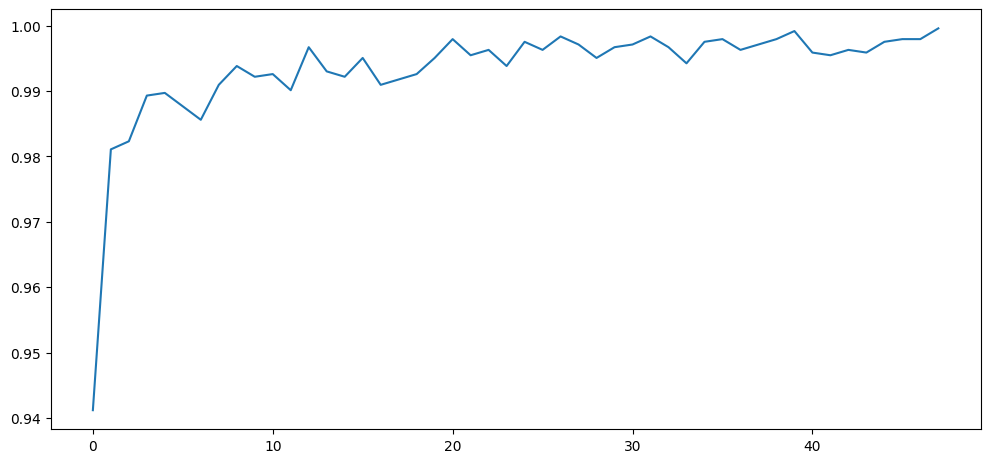

In [18]:

results_file = os.path.join(run_dir, 'training_results.json')

for base_model, custom_bool in zip(all_models, is_custom_model):
    model = generate_model(base_model, custom=custom_bool) # To display the model summary
    model.summary()
    training_results[model.name] = {}
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=os.path.join("architectures", f"{model.name}_architecture.png"))
    for dataset_id, train_dataset, val_dataset, steps_per_epoch, validation_steps in zip(combined_dataset_names, combined_training_datasets, combined_val_datasets, steps_per_epoch_list, validation_steps_list):
        model.load_weights(os.path.join(checkpoint_path, f"{model.name}_initial.weights.h5"))
        print(f"Training model: {model.name} on dataset: {dataset_id}")
        
        # Record the start time
        start_time = time.time()

        # Initial training of the model
        history = model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks_list
        )

        # Record the end time
        end_time = time.time()
        # Calculate the training time
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")

        model_ds_dir = os.path.join(run_dir, model.name, dataset_id)
        os.makedirs(model_ds_dir, exist_ok=True)
        # Save the model
        model.save(os.path.join(model_ds_dir, f"{model.name}_{dataset_id}.keras"))

        ### Evaluation stage ###
        optimal_threshold = full_eval(model_ds_dir, history, model, dataset_id, test_generator)
        
        training_results[model.name][dataset_id] = {
            'history': history.history,
            'training_time': training_time,
            'optimal_threshold': float(optimal_threshold),
            'train_dataset_size': steps_per_epoch * batch_size,
            'val_dataset_size': validation_steps * batch_size,
            "evaluation": model.evaluate(test_dataset, return_dict=True, steps=test_generator.samples // batch_size)
        }
        
        print(training_results)

        # Save the training results to a file after each iteration
        with open(results_file, 'w') as f:
            json.dump(training_results, f, indent=4)
        
        model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=metrics_list) # Reset the model for the next iteration

In [19]:
print("Brute force loop completed!")
print(f"All models and evaluations are available at: {run_dir}")

Brute force loop completed!
All models and evaluations are available at: runs\run_6


In [20]:
from pprint import pprint
pprint(history.history)
print(model.evaluate(test_dataset, return_dict=True, steps=test_generator.samples // batch_size))

{'accuracy': [0.7258230447769165,
              0.8127571940422058,
              0.8443930149078369,
              0.8751286268234253,
              0.904321014881134],
 'auc': [0.7971794009208679,
         0.8877936005592346,
         0.9179147481918335,
         0.9452250599861145,
         0.9639362692832947],
 'f1_score': [0.7686777114868164,
              0.8472543358802795,
              0.8729486465454102,
              0.8970165252685547,
              0.9209895133972168],
 'learning_rate': [0.0010000000474974513,
                   0.0010000000474974513,
                   0.0010000000474974513,
                   0.0010000000474974513,
                   0.0010000000474974513],
 'loss': [0.5846205949783325,
          0.41623160243034363,
          0.3561948239803314,
          0.289875328540802,
          0.23601625859737396],
 'precision': [0.7888932824134827,
               0.8418230414390564,
               0.8687848448753357,
               0.8913626074790955,
          